### **Initialization**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Downloading Libraries and Dependencies**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [29]:
#@ IMPORTING MODULES: UNCOMMENT BELOW:
# !pip install transformers
# !pip install datasets
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.nn.functional as F
from time import perf_counter
from pathlib import Path
from datasets import load_dataset
from datasets import load_metric
from transformers import Trainer
from transformers import pipeline
from transformers import TrainingArguments
from transformers import AutoTokenizer
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification

#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

### **Case Study: Intent Detection**

**The Dataset**
- We will use CLINC150 dataset. This dataset includes 22,500 inscope queries across 150 intents and 10 domains like banking and travel, and also includes 1,200 out of scope queries. 

In [6]:
#@ LOADING CLINC150 DATASET:
clinc = load_dataset("clinc_oos", "plus")                      # Loading dataset.
sample = clinc["test"][23]                                     # Initializing sample.
print(sample)                                                  # Inspection.
intents = clinc["test"].features["intent"]                     # Getting intent attribute.
print(intents.int2str(sample["intent"]))                       # Inspection.

Reusing dataset clinc_oos (/root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': 'how would i say i need directions if i were french', 'intent': 61}
translate


In [7]:
#@ INITIALIZING FINE-TUNED BERT BASE MODEL: 
bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"                    # Initializing model checkpoint.
pipe = pipeline("text-classification", model=bert_ckpt)                             # Initializing pretrained bert pipeline. 

In [8]:
#@ IMPLEMENTATION OF BERT:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""                                              # Initializing example query.
pipe(query)                                                                         # Implementation of bert model.

[{'label': 'car_rental', 'score': 0.5490034818649292}]

**Performance Benchmark**

In [9]:
#@ SKELETON OF PERFORMANCE BENCHMARK:
class PerformanceBenchmark:                                            
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
    
    def compute_accuracy(self):
        pass
    
    def compute_size(self):
        pass
    
    def time_pipeline(self):
        pass
    
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [11]:
#@ FUNCTION FOR COMPUTING ACCURACY:
accuracy_score = load_metric("accuracy")                            # Initializing accuracy metric.
def compute_accuracy(self):                                         # Defining compute accuracy function.
    preds, labels = [], []                                          # Initialization.
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]           # Initializing predictions.
        label = example["intent"]                                   # Initializing true label.
        preds.append(intents.str2int(pred))                         # Adding to predictions.
        labels.append(label)                                        # Adding to labels.
    accuracy = accuracy_score.compute(predictions=preds, 
                                      references=labels)            # Getting accuracy score.
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")     # Inspecting accuracy.
    return accuracy

#@ ADDING TO PERFORMANCE BENCHMARK:
PerformanceBenchmark.compute_accuracy = compute_accuracy            # Adding accuracy score.


In [13]:
#@ INSPECTING SIZE OF MODEL: UNCOMMENT BELOW: 
# list(pipe.model.state_dict().items())[23]                           

In [14]:
#@ FUNCTION FOR COMPUTING MODEL SIZE:
def compute_size(self):                                         # Defining function.
    state_dict = self.pipeline.model.state_dict()               # Initializing model dictionary.
    tmp_path = Path("model.pt")                                 # Initializing model path.
    torch.save(state_dict, tmp_path)                            # Saving the model.
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)     # Getting size in megabytes. 
    tmp_path.unlink()                                           # Deleting temporary file.
    print(f"Model size (MB) - {size_mb:.2f}")                   # Inspecting size.
    return {"size_mb": size_mb}

#@ ADDING TO PERFORMANCE BENCHMARK:
PerformanceBenchmark.compute_size = compute_size                # Adding to performance benchmark.

In [15]:
#@ CALCULATING TIME OF PIPELINE: 
for _ in range(3):
    start_time = perf_counter()                                 # Starting time.
    _ = pipe(query)                                             # Running pipeline.
    latency = perf_counter() - start_time                       # Calculating latency.
    print(f"Latency (ms) - {1000 * latency:.3f}")               # Inspection.

Latency (ms) - 128.402
Latency (ms) - 122.697
Latency (ms) - 129.930


In [16]:
#@ FUNCTION TO CALCULATE TIME OF PIPELINE:
def time_pipeline(self, query="What is the pin number for my account?"):    # Defining function.
    latencies = []                                                          # Initialization.
    for _ in range(10):
        _ = self.pipeline(query)                                            # Implementation of pipeline. 
    for _ in range(100):
        start_time = perf_counter()                                         # Starting time.
        _ = self.pipeline(query)                                            # Running pipeline.
        latency = perf_counter() - start_time                               # Calculating latency.
        latencies.append(latency)                                           # Adding latencies.
    time_avg_ms = 1000 * np.mean(latencies)                                 # Time average.
    time_std_ms = 1000 * np.std(latencies)                                  # Time standard deviation. 
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms":time_std_ms}      

#@ ADDING TO PERFORMANCE BENCHMARK:
PerformanceBenchmark.time_pipeline = time_pipeline                          # Adding to performance benchmark. 

In [17]:
#@ INSPECTING PERFORMANCE BENCHMARK:
pb = PerformanceBenchmark(pipe, clinc["test"])                              # Initializing performance benchmark class.
perf_metrics = pb.run_benchmark()                                           # Getting metrics. 

Model size (MB) - 418.16
Average latency (ms) - 85.48 +\- 29.42
Accuracy on test set - 0.867


### **Knowledge Distillation**
- Knowledge distillation is a general purpose method for training a smaller `student` model to mimic the behavior of a slower, larger, but better performing `teacher` model. 

In [18]:
#@ INITIALIZING DISTILLATION TRAINING ARGUMENTS: 
class DistillationTrainingArguments(TrainingArguments):                         # Defining class. 
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):            # Initializing constructor function. 
        super().__init__(*args, **kwargs)
        self.alpha = alpha                                                      # Initializing hyperparameters.
        self.temperature = temperature                                          # Initializing hyperparameters.

In [19]:
#@ INITIALIZING DISTILLATION TRAINER:
class DistillationTrainer(Trainer):                                             # Defining distillation trainer.
    def __init__(self, *args, teacher_model=None, **kwargs):                    # Initializing constructor function.
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model                                      # Initialization.
    
    def compute_loss(self, model, inputs, return_outputs=False):                # Defining compute loss function. 
        outputs_stu = model(**inputs)                                           # Implementation of model.
        loss_ce = outputs_stu.loss                                              # Getting cross entropy loss.
        logits_stu = outputs_stu.logits                                         # Getting logits.
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)                          # Implementation of model.
            logits_tea = outputs_tea.logits                                     # Getting logits.
        loss_fct = nn.KLDivLoss(reduction="batchmean")                          # Computing KL divergence. 
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),          # Normalizing with log softmax.
            F.softmax(logits_tea / self.args.temperature, dim=-1))              # Normalizing with softmax.
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd     # Weighted student loss.
        return (loss, outputs_stu) if return_outputs else loss

**Note:**
- The **KL divergence** expects the inputs in the form of log probabilities and labels as normal probabilities. So, we have used log softmax to normalize the student's logits while teacher's logits are converted to probabilities with a standard softmax.

**Good Student Initialization**

In [21]:
#@ INITIALIZING GOOD PRETRAINED STUDENT MODEL:
student_ckpt = "distilbert-base-uncased"                                    # Initializing student checkpoint. 
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)             # Initializing pretrained tokenizer.

#@ FUNCTION FOR TOKENIZATION:
def tokenize_text(batch):                                                   # Defining function. 
    return student_tokenizer(batch["text"], truncation=True)                # Implementation of tokenizer. 
clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"]) # Tokenizing whole dataset.
clinc_enc = clinc_enc.rename_column("intent", "labels")                     # Changing column name.

Loading cached processed dataset at /root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1/cache-5b3a8a0d3de51067.arrow


  0%|          | 0/4 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1/cache-f100bf1f0366ba32.arrow


In [22]:
#@ FUNCTION FOR COMPUTING METRICS:
def compute_metrics(pred):                                  # Function for computing metrics.
    predictions, labels = pred                              # Initialization.
    predictions = np.argmax(predictions, axis=1)            # Initializing predictions.
    return accuracy_score.compute(predictions=predictions,
                                  references=labels)        # Computing accuracy score.

In [23]:
#@ INITIALIZING DISTILLATION TRAINING ARGUMENTS:
batch_size = 48                                             # Initializing batch size.
finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"  # Initializing model checkpoint.
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy="epoch",
    num_train_epochs=5, learning_rate=2e-5, 
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, 
    alpha=1, weight_decay=0.01, 
    push_to_hub=False
)                                                           # Initializing training arguments.

In [24]:
#@ INITIALIZING AUTO MODEL CONFIGURATIONS:
id2label = pipe.model.config.id2label                           # Initializing mappings.
label2id = pipe.model.config.label2id                           # Initializing mappings.
num_labels = intents.num_classes                                # Initializing labels.
student_config = (AutoConfig.from_pretrained(
    student_ckpt, num_labels=num_labels, id2label=id2label,
    label2id=label2id))                                         # Initializing student model configurations.

In [25]:
#@ FUNCTION FOR MODEL INITIALIZATION:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")       # Initializing gpu.
def student_init():                                                         # Defining function.
    return (AutoModelForSequenceClassification.from_pretrained(
        student_ckpt, config=student_config).to(device))                    # Function for student model initialization.

In [26]:
#@ TRAINING DISTILLATION TRAINER:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"         # Initializing teacher model checkpoint.
teacher_model = (AutoModelForSequenceClassification.from_pretrained(
    teacher_ckpt, num_labels=num_labels).to(device))                        # Initializing teacher model.

#@ TRAINING DISTILLATION TRAINER:
distilbert_trainer = DistillationTrainer(
    model_init=student_init, teacher_model=teacher_model, 
    args=student_training_args, train_dataset=clinc_enc["train"], 
    eval_dataset=clinc_enc["validation"], 
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)           # Initializing distillation trainer.
distilbert_trainer.train()                                                  # Training distillation trainer.

https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpvsgwp3q8


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
creating metadata file for /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.306161,0.740323
2,3.807000,1.869868,0.835161
3,3.807000,1.153049,0.890000
4,1.682700,0.855760,0.907742
5,0.896600,0.771994,0.913548


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-clinc/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to distilbert-base-uncased-finetuned-clinc/checkpoint-1000
Configuration saved in distilbert-base-uncased-finetuned-clinc/checkpoint-1000/config.json
Model weights saved in distilbert-base-uncased-finetuned-clinc/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in d

TrainOutput(global_step=1590, training_loss=2.051182402604781, metrics={'train_runtime': 587.5529, 'train_samples_per_second': 129.776, 'train_steps_per_second': 2.706, 'total_flos': 413896353421488.0, 'train_loss': 2.051182402604781, 'epoch': 5.0})

In [27]:
#@ INSPECTING PERFORMANCE BENCHMARK:
finetuned_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"     # Initializing finetuned model checkpoint.
pipe = pipeline("text-classification", model=finetuned_ckpt)                    # Initializing model pipeline.
optim_type = "DistilBERT"                                                       # Initialization.
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)           # Initializing performance benchmark.
perf_metrics.update(pb.run_benchmark())                                         # Getting metrics. 

https://huggingface.co/transformersbook/distilbert-base-uncased-finetuned-clinc/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpl6yvsbkq


Downloading:   0%|          | 0.00/8.01k [00:00<?, ?B/s]

storing https://huggingface.co/transformersbook/distilbert-base-uncased-finetuned-clinc/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/b260e9da00881ac757ff45d4b2e2fdd57c1bffe839137733f8e862e013e80562.840d34be4a5ee5f1a66a2b196122fb7d112229d259e5712e44e13ffc8ec27b68
creating metadata file for /root/.cache/huggingface/transformers/b260e9da00881ac757ff45d4b2e2fdd57c1bffe839137733f8e862e013e80562.840d34be4a5ee5f1a66a2b196122fb7d112229d259e5712e44e13ffc8ec27b68
loading configuration file https://huggingface.co/transformersbook/distilbert-base-uncased-finetuned-clinc/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/b260e9da00881ac757ff45d4b2e2fdd57c1bffe839137733f8e862e013e80562.840d34be4a5ee5f1a66a2b196122fb7d112229d259e5712e44e13ffc8ec27b68
Model config DistilBertConfig {
  "_name_or_path": "transformersbook/distilbert-base-uncased-finetuned-clinc",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

storing https://huggingface.co/transformersbook/distilbert-base-uncased-finetuned-clinc/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/299152d5c04a69678bc32e7081655a202e87ced1d401592c763fc404373adefc.6546e0b39d5da3515b1ee1d9d5a77edaa57fddce919158396e03eb3d01ce2d39
creating metadata file for /root/.cache/huggingface/transformers/299152d5c04a69678bc32e7081655a202e87ced1d401592c763fc404373adefc.6546e0b39d5da3515b1ee1d9d5a77edaa57fddce919158396e03eb3d01ce2d39
loading weights file https://huggingface.co/transformersbook/distilbert-base-uncased-finetuned-clinc/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/299152d5c04a69678bc32e7081655a202e87ced1d401592c763fc404373adefc.6546e0b39d5da3515b1ee1d9d5a77edaa57fddce919158396e03eb3d01ce2d39
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

storing https://huggingface.co/transformersbook/distilbert-base-uncased-finetuned-clinc/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/d5833481b51591772dc05742ee8ff81f90cd17e8a9dcabe1c13ce1030c94a572.42154c5fd30bfa7e34941d0d8ad26f8a3936990926fbe06b2da76dd749b1c6d4
creating metadata file for /root/.cache/huggingface/transformers/d5833481b51591772dc05742ee8ff81f90cd17e8a9dcabe1c13ce1030c94a572.42154c5fd30bfa7e34941d0d8ad26f8a3936990926fbe06b2da76dd749b1c6d4
https://huggingface.co/transformersbook/distilbert-base-uncased-finetuned-clinc/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpts3depd0


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/transformersbook/distilbert-base-uncased-finetuned-clinc/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/2c935eb35425fd20b0d3c39ca3f75cb695e488ea33011df00f5e48c01a8e55b0.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/2c935eb35425fd20b0d3c39ca3f75cb695e488ea33011df00f5e48c01a8e55b0.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/transformersbook/distilbert-base-uncased-finetuned-clinc/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpylwlm2o7


Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

storing https://huggingface.co/transformersbook/distilbert-base-uncased-finetuned-clinc/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/b5e18c5d15cb77f9e3470dd4394e816170241bcb63077c9cc8a8556db639d4a3.59b3fc05e6327297545bda94ff9c1ef4b08d7fe92a7822f2260c164f54d0d152
creating metadata file for /root/.cache/huggingface/transformers/b5e18c5d15cb77f9e3470dd4394e816170241bcb63077c9cc8a8556db639d4a3.59b3fc05e6327297545bda94ff9c1ef4b08d7fe92a7822f2260c164f54d0d152
https://huggingface.co/transformersbook/distilbert-base-uncased-finetuned-clinc/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmps11x6fs3


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/transformersbook/distilbert-base-uncased-finetuned-clinc/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/2595e78debd7a1082d8f01c336df4a7cb20b2d296adb5ac8edc4824781bf37f7.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/2595e78debd7a1082d8f01c336df4a7cb20b2d296adb5ac8edc4824781bf37f7.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/transformersbook/distilbert-base-uncased-finetuned-clinc/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/2c935eb35425fd20b0d3c39ca3f75cb695e488ea33011df00f5e48c01a8e55b0.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/transformersbook/distilbert-base-uncased-finetuned-clinc/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/b5e18c5d15cb77f9e3470dd4394e8

Model size (MB) - 255.89
Average latency (ms) - 39.31 +\- 2.63
Accuracy on test set - 0.858


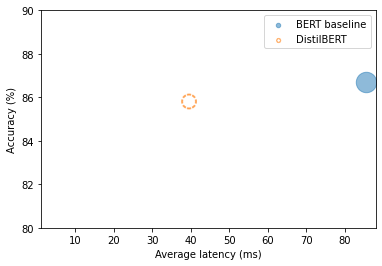

In [31]:
#@ FUNCTION FOR PLOTTING ACCURACY ACROSS LATENCY:
def plot_metrics(perf_metrics, current_optim_type):          
    df = pd.DataFrame.from_dict(perf_metrics, orient="index") 
    for idx in df.index:
        df_opt = df.loc[idx]
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
    legend = plt.legend(bbox_to_anchor=(1, 1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])
    plt.ylim(80, 90)
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

#@ IMPLEMENTATION OF FUNCTION:
plot_metrics(perf_metrics, optim_type)